In [34]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [35]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [36]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [37]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\saved_model\resize_simclr_modelepoch250.pth' 
simclr_model = torch.load(full_model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_2088\3495648145.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [57]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label, img_path

def load_data(root_dir):

    #classes = ['cond7_all', 'sd_only','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_only','ex'] # curated full dataset



    #classes = ['uncure_cond7_40', 'sdonly_40','ex'] # 40 subset
    #classes = ['cure_cond7_40', 'sdonly_40','ex'] # curated 40 subset

    #inference

    classes = ['cond7_all', 'sd_plus_dsclose','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_plus_dsclose','ex'] # curated full dataset



    #classes = ['uncure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference
    #classes = ['cure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference




    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

#image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification\cluster_40"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'cond7_all': 472, 'sd_plus_dsclose': 125, 'ex': 40}


In [58]:
for anchor,label, path in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    print(path)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0])
['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classificat

In [59]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels, paths = [], [], []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        print(f"Batch labels shape: {batch_paths}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        paths.extend(batch_paths) 

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")
    print(f"Number of paths after concatenation: {len(paths)}")

    return feats, labels, paths

In [60]:
# Extract features for train and test datasets
feats, labels, paths = prepare_data_features(simclr_model, loader_labeled)

  2%|▎         | 1/40 [00:00<00:30,  1.28it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

  5%|▌         | 2/40 [00:01<00:29,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

  8%|▊         | 3/40 [00:02<00:27,  1.33it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g9_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7

 10%|█         | 4/40 [00:03<00:27,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 12%|█▎        | 5/40 [00:03<00:26,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\cl

 15%|█▌        | 6/40 [00:04<00:26,  1.29it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 18%|█▊        | 7/40 [00:05<00:25,  1.30it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\cl

 20%|██        | 8/40 [00:06<00:24,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds1b_g5_E4.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g3_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\class

 22%|██▎       | 9/40 [00:06<00:23,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 25%|██▌       | 10/40 [00:07<00:22,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\cl

 28%|██▊       | 11/40 [00:08<00:22,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G02-T01.tiff', 'C:\\Users\\k54739\\Bib

 30%|███       | 12/40 [00:09<00:21,  1.31it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G09-T01.tiff', 'C:\

 32%|███▎      | 13/40 [00:09<00:20,  1.30it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 35%|███▌      | 14/40 [00:11<00:22,  1.14it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_c10.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classificati

 38%|███▊      | 15/40 [00:12<00:26,  1.04s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds62_g2_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_D10-T01.tiff', 'C:\\Users\\k54

 40%|████      | 16/40 [00:13<00:26,  1.12s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C7.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifi

 42%|████▎     | 17/40 [00:15<00:27,  1.19s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g3_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g9_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classificati

 45%|████▌     | 18/40 [00:16<00:26,  1.20s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification

 48%|████▊     | 19/40 [00:17<00:25,  1.21s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 50%|█████     | 20/40 [00:18<00:24,  1.21s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G09-T01.tiff', 'C:\\Users\\k54739\\Bib

 52%|█████▎    | 21/40 [00:20<00:23,  1.21s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C11.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classif

 55%|█████▌    | 22/40 [00:21<00:22,  1.24s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_

 57%|█████▊    | 23/40 [00:22<00:21,  1.24s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G08-T01.tiff', 'C:\\Users\\k54739\\Bib

 60%|██████    | 24/40 [00:23<00:19,  1.23s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 62%|██████▎   | 25/40 [00:25<00:18,  1.22s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g5_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F09-T01.tiff', 'C:\\Users\\k54

 65%|██████▌   | 26/40 [00:26<00:17,  1.23s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E08-T01.tiff', 'C:\\Users\\k54739\\Bib

 68%|██████▊   | 27/40 [00:27<00:16,  1.27s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g5_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g2_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g5_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds1b_g5_E5.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_C08-T01.tiff

 70%|███████   | 28/40 [00:28<00:15,  1.27s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g8_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new

 72%|███████▎  | 29/40 [00:30<00:13,  1.27s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g9_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thes

 75%|███████▌  | 30/40 [00:31<00:13,  1.31s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\cl

 78%|███████▊  | 31/40 [00:32<00:11,  1.32s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds1b_g5_E2.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification

 80%|████████  | 32/40 [00:34<00:10,  1.28s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F02-T01.tiff', 'C:\

 82%|████████▎ | 33/40 [00:35<00:08,  1.28s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g5_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D08-T01.tif

 85%|████████▌ | 34/40 [00:36<00:07,  1.27s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g2_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifi

 88%|████████▊ | 35/40 [00:37<00:06,  1.27s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C04-T01.tiff', 'C:\\Users\\k54739\\Bib

 90%|█████████ | 36/40 [00:39<00:05,  1.31s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 92%|█████████▎| 37/40 [00:40<00:03,  1.32s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\

 95%|█████████▌| 38/40 [00:41<00:02,  1.29s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g2_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g2_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_C9.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classificat

 98%|█████████▊| 39/40 [00:43<00:01,  1.28s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g5_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D10-T01.tiff', 'C:\\Users\\k54

100%|██████████| 40/40 [00:44<00:00,  1.10s/it]

Batch features shape: torch.Size([13, 512])
Batch labels shape: torch.Size([13])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_E09-T01.tiff', 'C:\

In [61]:
# Convert features and labels to NumPy arrays
feats_np = feats.numpy()
labels_np = labels.numpy()

# Ensure that paths is a list of the correct length
assert len(paths) == feats_np.shape[0], "Mismatch between number of features and paths"

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (637, 512)
Shape of labels: (637,)


From scratch

In [65]:
import numpy as np
from scipy.stats import mode

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Euclidean distance
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids.copy()
    
    # Initialize idx as array of zeros with correct shape
    prev_idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(max_iters):
        # Assign points to closest centroids
        idx = find_closest_centroids(X, centroids)
        
        # Check for convergence
        if np.all(idx == prev_idx):
            break
            
        # Update centroids
        centroids = compute_centroids(X, idx, K)
        prev_idx = idx.copy()
    
    return centroids, idx

# Function to reorder labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)
    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        most_common_label = mode(true_labels[mask], axis=None).mode
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]
        reordered_labels[mask] = most_common_label
    return reordered_labels

# Main function to perform clustering
def perform_clustering(X, K, n_runs=100):
    max_accuracy = 0
    best_centroids = None
    best_idx = None
    
    for trial in range(n_runs):
        print(f"Trial {trial + 1}/{n_runs}")
        
        # Initialize and run K-means
        initial_centroids = kMeans_init_centroids(X, K)
        centroids, idx = run_kMeans(X, initial_centroids, max_iters=100)
        
        # Reorder labels and calculate accuracy
        reordered_idx = reorder_labels(labels_np, idx)
        accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
        
        print(f"Accuracy for trial {trial + 1}: {accuracy:.2f}%")
        
        # Update best results if current accuracy is better
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_centroids = centroids.copy()
            best_idx = idx.copy()
    
    print(f"\nBest accuracy achieved: {max_accuracy:.2f}%")
    return best_centroids, best_idx, max_accuracy

# Run the clustering
K = 3
best_centroids, best_idx, max_accuracy = perform_clustering(feats_np, K)

# Print clustering results
print("\nClustering Results:")
print(f"idx shape: {best_idx.shape}")
print(f"Unique clusters: {np.unique(best_idx)}")
print(f"Points per cluster: {np.bincount(best_idx)}")



Trial 1/100
Accuracy for trial 1: 74.10%
Trial 2/100
Accuracy for trial 2: 74.10%
Trial 3/100
Accuracy for trial 3: 74.10%
Trial 4/100
Accuracy for trial 4: 74.10%
Trial 5/100
Accuracy for trial 5: 74.10%
Trial 6/100
Accuracy for trial 6: 74.10%
Trial 7/100
Accuracy for trial 7: 74.10%
Trial 8/100
Accuracy for trial 8: 87.44%
Trial 9/100
Accuracy for trial 9: 74.10%
Trial 10/100
Accuracy for trial 10: 74.10%
Trial 11/100
Accuracy for trial 11: 74.10%
Trial 12/100
Accuracy for trial 12: 74.10%
Trial 13/100
Accuracy for trial 13: 74.10%
Trial 14/100
Accuracy for trial 14: 74.10%
Trial 15/100
Accuracy for trial 15: 74.10%
Trial 16/100
Accuracy for trial 16: 74.10%
Trial 17/100
Accuracy for trial 17: 74.10%
Trial 18/100
Accuracy for trial 18: 74.10%
Trial 19/100
Accuracy for trial 19: 74.10%
Trial 20/100
Accuracy for trial 20: 74.10%
Trial 21/100
Accuracy for trial 21: 78.18%
Trial 22/100
Accuracy for trial 22: 74.10%
Trial 23/100
Accuracy for trial 23: 74.10%
Trial 24/100
Accuracy for tri

In [67]:
335+116+40

491

In [68]:
491/637

0.7708006279434851

In [63]:
106/120

0.8833333333333333

In [55]:
109+166+40

315

In [56]:
315/445

0.7078651685393258

In [46]:
40+26+40

106

c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


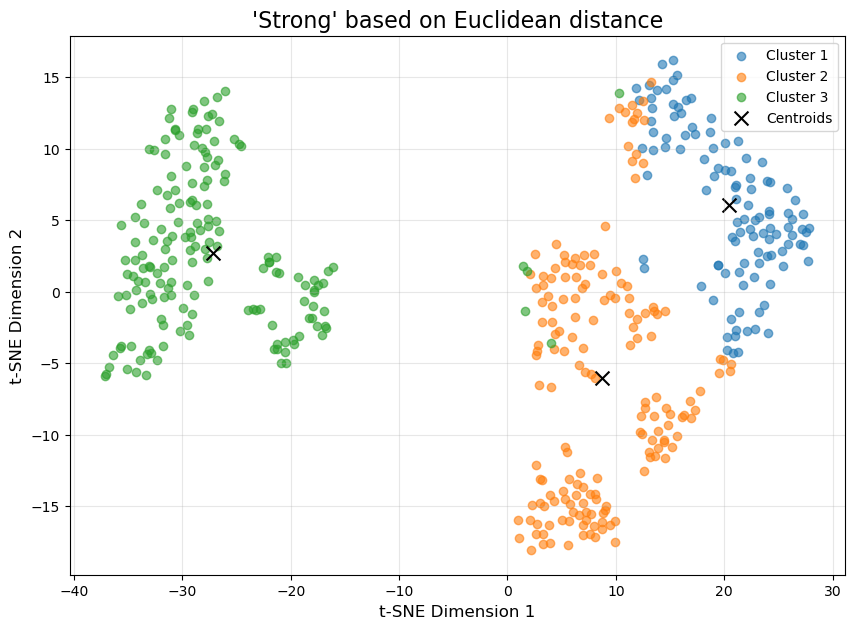

In [47]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE to the normalized features (not centroids separately)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(feats_np)  # Project features to 2D

# Map centroids to 2D space using the same transformation
centroids_2d = np.array([
    np.mean(features_2d[best_idx == cluster_id], axis=0)
    for cluster_id in range(K)
])

# Create a scatter plot of the t-SNE-transformed features
plt.figure(figsize=(10, 7))
for cluster_id in range(K):
    cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", alpha=0.6)

# Plot the centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("'Strong' based on Euclidean distance", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


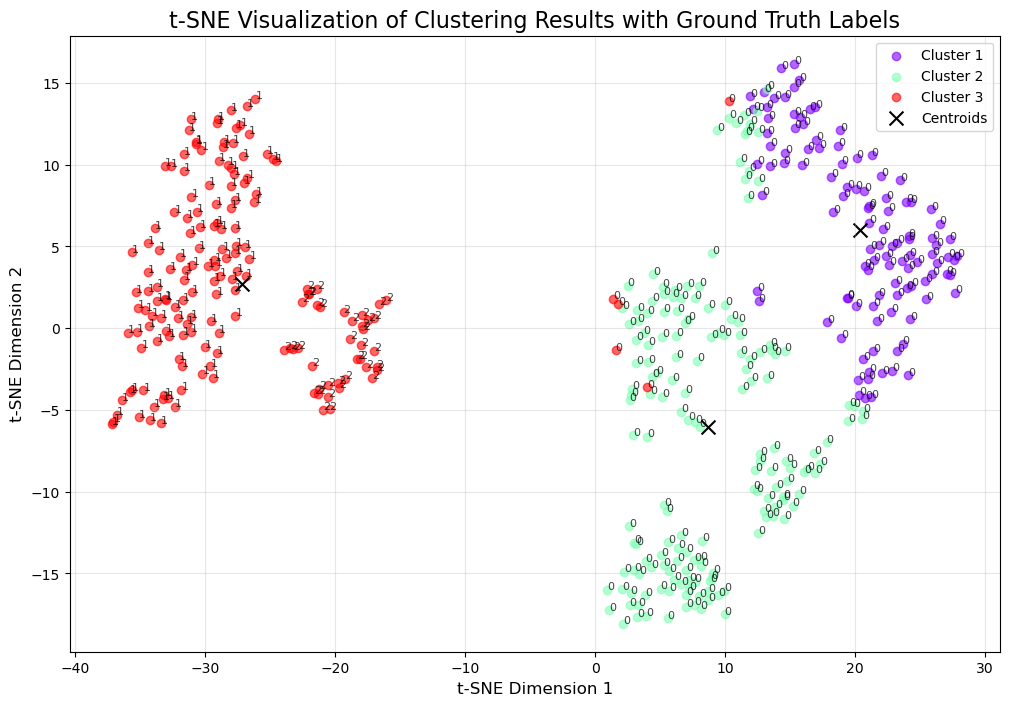

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE to the normalized features (not centroids separately)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(feats_np)  # Project features to 2D

# Map centroids to 2D space using the same transformation
centroids_2d = np.array([
    np.mean(features_2d[best_idx == cluster_id], axis=0)
    for cluster_id in range(K)
])

# Create a scatter plot of the t-SNE-transformed features
plt.figure(figsize=(12, 8))

# Define color map for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, K))

# Plot each cluster with points and ground truth labels
for cluster_id in range(K):
    cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
    cluster_labels = labels_np[best_idx == cluster_id]  # True labels for the current cluster

    # Scatter plot for cluster points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

    # Annotate each point with its true label
    for i, label in enumerate(cluster_labels):
        plt.annotate(str(label), 
                     (cluster_points[i, 0], cluster_points[i, 1]), 
                     fontsize=8, alpha=0.75)

# Plot centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
            color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("t-SNE Visualization of Clustering Results with Ground Truth Labels", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


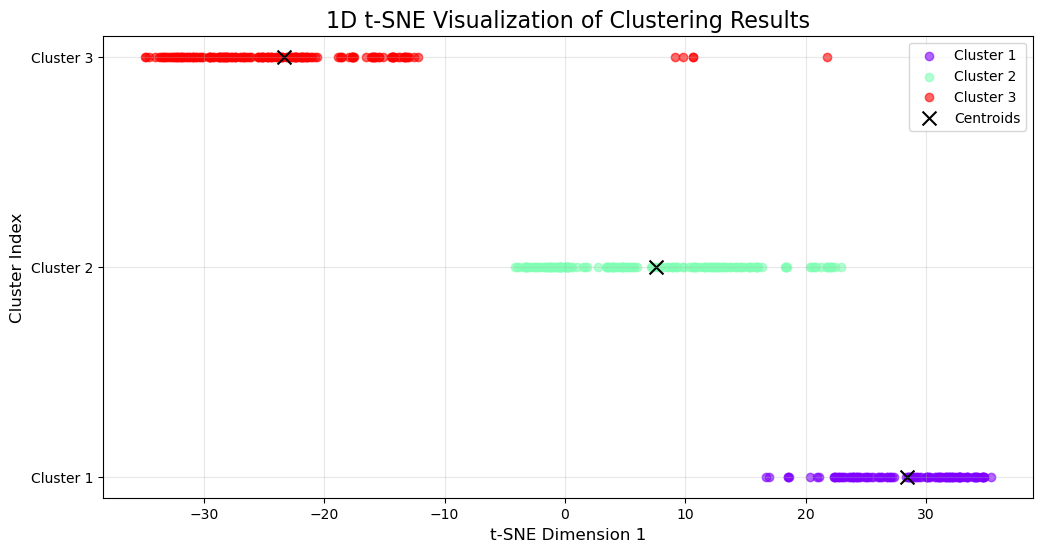

In [49]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE to the normalized features with n_components=1
tsne_1d = TSNE(n_components=1, random_state=42, perplexity=30, n_iter=1000)
features_1d = tsne_1d.fit_transform(feats_np).flatten()  # Project features to 1D and flatten

# Map centroids to 1D space using the mean of cluster points in t-SNE space
centroids_1d = np.array([
    np.mean(features_1d[best_idx == cluster_id]) 
    for cluster_id in range(K)
])

# Create a 1D scatter plot of the t-SNE-transformed features
plt.figure(figsize=(12, 6))

# Define colors for each cluster
colors = plt.cm.rainbow(np.linspace(0, 1, K))

# Plot each cluster
for cluster_id in range(K):
    cluster_points = features_1d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points, [cluster_id] * len(cluster_points), 
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

# Plot the centroids
plt.scatter(centroids_1d, range(K), color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("1D t-SNE Visualization of Clustering Results", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("Cluster Index", fontsize=12)
plt.yticks(range(K), [f"Cluster {i+1}" for i in range(K)])
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


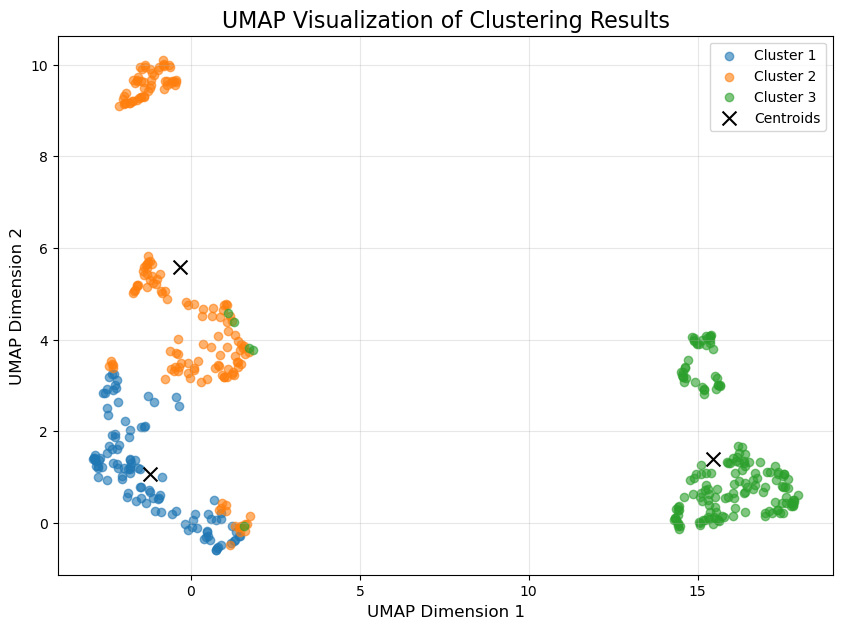

In [50]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Apply UMAP to the normalized features (not centroids separately)
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
features_2d = umap_model.fit_transform(feats_np)  # Project features to 2D

# Map centroids to 2D space using the mean of the cluster points in UMAP space
centroids_2d = np.array([
    np.mean(features_2d[best_idx == cluster_id], axis=0)
    for cluster_id in range(K)
])

# Create a scatter plot of the UMAP-transformed features
plt.figure(figsize=(10, 7))
for cluster_id in range(K):
    cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", alpha=0.6)

# Plot the centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("UMAP Visualization of Clustering Results", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


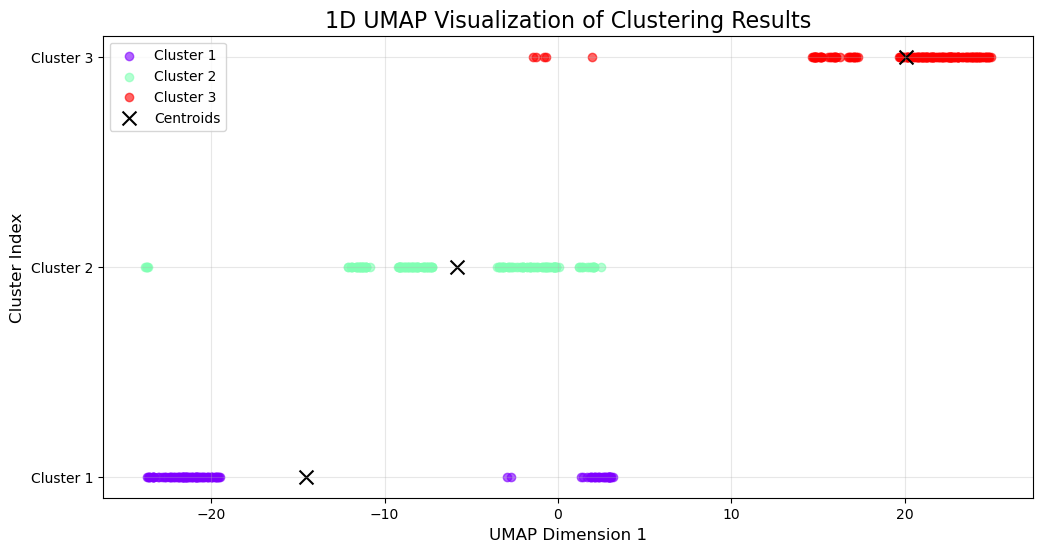

In [51]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Apply UMAP to reduce the normalized features to 1D
umap_1d = umap.UMAP(n_components=1, random_state=42)
features_1d = umap_1d.fit_transform(feats_np).flatten()  # Reduce to 1D and flatten

# Calculate centroids in 1D space using the mean of cluster points
centroids_1d = np.array([
    np.mean(features_1d[best_idx == cluster_id]) 
    for cluster_id in range(K)
])

# Create a 1D scatter plot of the UMAP-transformed features
plt.figure(figsize=(12, 6))

# Define colors for each cluster
colors = plt.cm.rainbow(np.linspace(0, 1, K))

# Plot each cluster
for cluster_id in range(K):
    cluster_points = features_1d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points, [cluster_id] * len(cluster_points), 
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

# Plot the centroids
plt.scatter(centroids_1d, range(K), color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("1D UMAP Visualization of Clustering Results", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("Cluster Index", fontsize=12)
plt.yticks(range(K), [f"Cluster {i+1}" for i in range(K)])
plt.legend()
plt.grid(alpha=0.3)
plt.show()


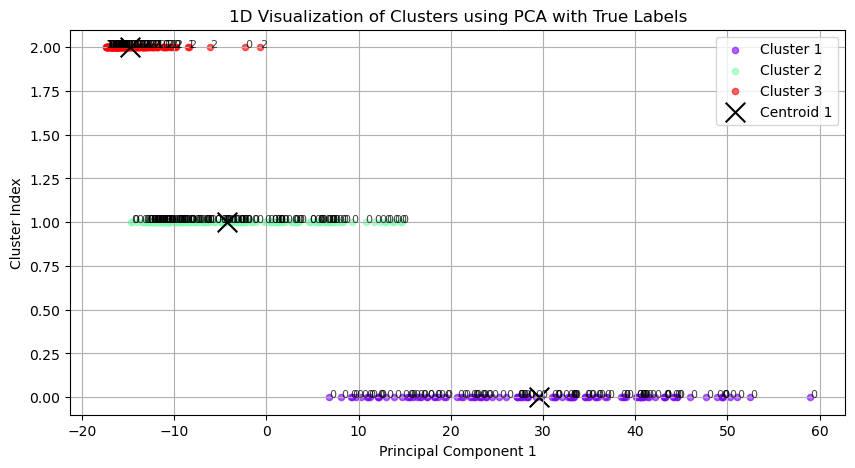


1D PCA values in ascending order: [-17.452625   -17.3559     -17.311794   -17.293732   -17.293257
 -17.25385    -17.241194   -17.237278   -17.237051   -17.23675
 -17.234158   -17.158134   -17.156824   -17.030596   -17.02937
 -17.004395   -16.933416   -16.916018   -16.901987   -16.887844
 -16.873632   -16.859108   -16.854898   -16.809563   -16.762907
 -16.76153    -16.756037   -16.734352   -16.730564   -16.705599
 -16.703817   -16.700857   -16.683971   -16.662794   -16.646463
 -16.626526   -16.62031    -16.587053   -16.48443    -16.48364
 -16.475464   -16.467813   -16.443106   -16.442286   -16.43745
 -16.404823   -16.361034   -16.353071   -16.325409   -16.32379
 -16.291332   -16.281364   -16.273726   -16.25155    -16.248034
 -16.221416   -16.21107    -16.19924    -16.191938   -16.18083
 -16.158878   -16.13993    -16.135223   -16.124035   -16.120878
 -16.110811   -16.073242   -16.061255   -16.010593   -16.008102
 -15.988099   -15.948817   -15.899248   -15.894012   -15.863069
 -15.855203

In [52]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to reduce the dimensionality of data points and centroids to 1D using PCA
def reduce_to_1D_pca(X, centroids):
    # Initialize PCA with 1 component
    pca = PCA(n_components=1)
    
    # Apply PCA to the data points (X) and centroids
    X_1D = pca.fit_transform(X)  # Reducing original data points
    centroids_1D = pca.transform(centroids)  # Reducing centroids

    return X_1D, centroids_1D

# Function to plot 1D visualization of clustered data points and centroids with true labels
def plot_1D_clusters_with_labels(X_1D, centroids_1D, idx, labels, K):
    plt.figure(figsize=(10, 5))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_1D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points, [k] * len(cluster_points), 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6, s=20)
        
        # Annotate each point with its true label
        for i in range(len(cluster_points)):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i], k), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    for k in range(K):
        plt.scatter(centroids_1D[k], k, 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else "")

    plt.title("1D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Cluster Index")
    plt.legend()
    plt.grid()
    plt.show()

# Apply PCA after K-Means clustering for 1D visualization
X_1D_pca, centroids_1D_pca = reduce_to_1D_pca(feats_np, best_centroids)

# Plot the 1D clusters with centroids and true labels
plot_1D_clusters_with_labels(X_1D_pca, centroids_1D_pca, best_idx, labels_np, K)

# Print the 1D values (PCA scores) in ascending order
sorted_X_1D = np.sort(X_1D_pca.flatten())  # Flatten and sort the PCA scores
print("\n1D PCA values in ascending order:", sorted_X_1D)

# Sort the 1D centroid values and map to labels
sorted_centroids_idx = np.argsort(centroids_1D_pca.flatten())
true_labels_mapping = ['control', 'sd', 'ex']
sorted_labels = [true_labels_mapping[i] for i in sorted_centroids_idx]

# Print sorted centroids with their corresponding true labels
print("\nCentroids in ascending order:")
for i, idx in enumerate(sorted_centroids_idx):
    print(f"Centroid {i+1}: {sorted_labels[i]}, Value: {centroids_1D_pca[idx][0]:.4f}")

In [53]:
import numpy as np

def calculate_middle_cluster_accuracy(X_1D, idx, centroids_1D):
    # Convert idx to array if it's not already
    if not isinstance(idx, np.ndarray):
        idx = np.array(idx)
    
    # Ensure idx is the same length as X_1D
    if idx.shape != (len(X_1D),):
        print("Warning: Reshaping idx to match data points")
        idx = np.full(len(X_1D), idx)
    
    print("Debugging Information:")
    print(f"Shape of X_1D: {X_1D.shape}")
    print(f"Shape of idx (after fix): {idx.shape}")
    print(f"Shape of centroids_1D: {centroids_1D.shape}")
    print(f"Unique cluster indices: {np.unique(idx)}")
    
    # Sort centroids and get their indices
    centroid_values = centroids_1D.flatten()
    sorted_indices = np.argsort(centroid_values)
    print(f"Centroid values: {centroid_values}")
    print(f"Sorted centroid indices: {sorted_indices}")
    
    # Map old cluster indices to new ordered indices (0, 1, 2)
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    
    # Reindex the clusters to be 0, 1, 2 in order of centroid values
    new_idx = np.zeros_like(idx)
    for old_idx, new_idx_val in index_mapping.items():
        new_idx[idx == old_idx] = new_idx_val
    
    # Now we work with the reindexed clusters
    # Get points belonging to each cluster
    first_cluster_points = X_1D[new_idx == 0]
    middle_cluster_points = X_1D[new_idx == 1]
    third_cluster_points = X_1D[new_idx == 2]
    
    print(f"\nCluster sizes after reindexing:")
    print(f"First cluster points: {len(first_cluster_points)}")
    print(f"Middle cluster points: {len(middle_cluster_points)}")
    print(f"Third cluster points: {len(third_cluster_points)}")
    
    # Check if any clusters are empty
    if len(first_cluster_points) == 0 or len(middle_cluster_points) == 0 or len(third_cluster_points) == 0:
        raise ValueError("One or more clusters are empty after reindexing. Please check cluster assignments.")
    
    # Calculate boundary values
    first_cluster_max = np.max(first_cluster_points)
    third_cluster_min = np.min(third_cluster_points)
    
    # Count errors
    errors_below = np.sum(middle_cluster_points < first_cluster_max)
    errors_above = np.sum(middle_cluster_points > third_cluster_min)
    total_errors = errors_below + errors_above
    total_points = 40+40+40
    # Calculate accuracy
    total_middle_points = len(middle_cluster_points)
    accuracy = (total_points - total_errors) / total_points
    
    # Print boundary information
    print(f"\nBoundary Information:")
    print(f"First cluster range: [{np.min(first_cluster_points):.4f}, {first_cluster_max:.4f}]")
    print(f"Middle cluster range: [{np.min(middle_cluster_points):.4f}, {np.max(middle_cluster_points):.4f}]")
    print(f"Third cluster range: [{third_cluster_min:.4f}, {np.max(third_cluster_points):.4f}]")
    
    return {
        'accuracy': accuracy,
        'total_points': total_middle_points,
        'errors_below': errors_below,
        'errors_above': errors_above,
        'total_errors': total_errors,
        'first_cluster_max': first_cluster_max,
        'third_cluster_min': third_cluster_min
    }

# Calculate middle cluster accuracy using the best results
try:
    results = calculate_middle_cluster_accuracy(X_1D_pca, best_idx, centroids_1D_pca)
    
    print(f"\nMiddle Cluster Analysis Results:")
    print(f"Total points in middle cluster: {results['total_points']}")
    print(f"Errors below first cluster max: {results['errors_below']}")
    print(f"Errors above third cluster min: {results['errors_above']}")
    print(f"Total errors: {results['total_errors']}")
    print(f"Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Additional debugging needed. Please check cluster assignments")

Debugging Information:
Shape of X_1D: (445, 1)
Shape of idx (after fix): (445,)
Shape of centroids_1D: (3, 1)
Unique cluster indices: [0 1 2]
Centroid values: [ 29.58918464  -4.31236498 -14.76100008]
Sorted centroid indices: [2 1 0]

Cluster sizes after reindexing:
First cluster points: 170
Middle cluster points: 166
Third cluster points: 109

Boundary Information:
First cluster range: [-17.4526, -0.6727]
Middle cluster range: [-14.6992, 14.6618]
Third cluster range: [6.8259, 58.9734]

Middle Cluster Analysis Results:
Total points in middle cluster: 166
Errors below first cluster max: 116
Errors above third cluster min: 18
Total errors: 134
Accuracy: -0.1167 (-11.67%)


In [54]:
import numpy as np

def calculate_outer_cluster_errors(X_1D, idx, centroids_1D):
    # Convert idx to array if it's not already
    if not isinstance(idx, np.ndarray):
        idx = np.array(idx)
    
    # Ensure idx is the same length as X_1D
    if idx.shape != (len(X_1D),):
        print("Warning: Reshaping idx to match data points")
        idx = np.full(len(X_1D), idx)
    
    # Sort centroids and get their indices
    centroid_values = centroids_1D.flatten()
    sorted_indices = np.argsort(centroid_values)
    
    # Map old cluster indices to new ordered indices (0, 1, 2)
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    
    # Reindex the clusters to be 0, 1, 2 in order of centroid values
    new_idx = np.zeros_like(idx)
    for old_idx, new_idx_val in index_mapping.items():
        new_idx[idx == old_idx] = new_idx_val
    
    # Get points belonging to each cluster
    first_cluster_points = X_1D[new_idx == 0]
    middle_cluster_points = X_1D[new_idx == 1]
    third_cluster_points = X_1D[new_idx == 2]
    
    # Check if any clusters are empty
    if len(first_cluster_points) == 0 or len(middle_cluster_points) == 0 or len(third_cluster_points) == 0:
        raise ValueError("One or more clusters are empty after reindexing")
    
    # Calculate boundary values for middle cluster
    middle_cluster_min = np.min(middle_cluster_points)
    middle_cluster_max = np.max(middle_cluster_points)
    
    # Calculate errors for outer clusters
    first_cluster_errors = np.sum(first_cluster_points > middle_cluster_min)
    third_cluster_errors = np.sum(third_cluster_points < middle_cluster_max)
    
    total_points = len(first_cluster_points) + len(middle_cluster_points) + len(third_cluster_points)
    total_errors = first_cluster_errors + third_cluster_errors
    accuracy = (total_points - total_errors) / total_points
    
    # Print detailed information
    print(f"\nCluster Ranges:")
    print(f"First cluster:  [{np.min(first_cluster_points):.4f}, {np.max(first_cluster_points):.4f}]")
    print(f"Middle cluster: [{middle_cluster_min:.4f}, {middle_cluster_max:.4f}]")
    print(f"Third cluster:  [{np.min(third_cluster_points):.4f}, {np.max(third_cluster_points):.4f}]")
    
    return {
        'accuracy': accuracy,
        'first_cluster_errors': first_cluster_errors,
        'third_cluster_errors': third_cluster_errors,
        'total_errors': total_errors,
        'middle_cluster_min': middle_cluster_min,
        'middle_cluster_max': middle_cluster_max,
        'first_cluster_size': len(first_cluster_points),
        'middle_cluster_size': len(middle_cluster_points),
        'third_cluster_size': len(third_cluster_points)
    }

# Example usage:
try:
    results = calculate_outer_cluster_errors(X_1D_pca, best_idx, centroids_1D_pca)
    
    print(f"\nOuter Clusters Error Analysis:")
    print(f"First cluster points above middle min: {results['first_cluster_errors']}")
    print(f"Third cluster points below middle max: {results['third_cluster_errors']}")
    print(f"Total errors: {results['total_errors']}")
    print(f"Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Additional debugging needed. Please check cluster assignments")


Cluster Ranges:
First cluster:  [-17.4526, -0.6727]
Middle cluster: [-14.6992, 14.6618]
Third cluster:  [6.8259, 58.9734]

Outer Clusters Error Analysis:
First cluster points above middle min: 62
Third cluster points below middle max: 14
Total errors: 76
Accuracy: 0.8292 (82.92%)
